In [3]:
import json, os
import cv2
import torch
from multiprocessing import Pool, Manager
from aquabyte.data_access_utils import S3AccessUtils, RDSAccessUtils
from aquabyte.akpd import AKPD
from aquabyte.template_matching import find_matches_and_homography
from aquabyte.biomass_estimator import NormalizeCentered2D, NormalizedStabilityTransform, ToTensor, Network
from aquabyte.akpd_scorer import AKPDNormalizationTransform, AKPDScorerNetwork
import numpy as np
from matplotlib import pyplot as plt
import time

In [6]:
# extract sample dataset
s3_access_utils = S3AccessUtils('/root/data')
rds_access_utils = RDSAccessUtils(json.load(open(os.environ['DATA_WAREHOUSE_SQL_CREDENTIALS'])))

query = """
    SELECT * FROM prod.crop_annotation ca
    INNER JOIN prod.annotation_state pas on pas.id=ca.annotation_state_id
    WHERE ca.service_id = (SELECT ID FROM prod.service where name='LATI')
    AND ca.left_crop_url is not null
    AND ca.right_crop_url is not null
    AND ca.pen_id = 61
    AND ca.annotation_state_id=1
    AND ca.captured_at between '2019-11-09' and '2019-11-13';
"""

df = rds_access_utils.extract_from_database(query)

aws_credentials = json.load(open(os.environ['AWS_CREDENTIALS']))
akpd = AKPD(aws_credentials)

# initialize data transforms so that we can run inference with AKPD scorer network
normalize_centered_2D_transform_akpd = NormalizeCentered2D(rotate=False, center=True)
akpd_normalization_transform = AKPDNormalizationTransform()
to_tensor_transform = ToTensor()

# initialize data transforms so that we can run inference with biomass neural network
normalize_centered_2D_transform_biomass = NormalizeCentered2D()
normalized_stability_transform = NormalizedStabilityTransform()

# load neural network weights
biomass_network = torch.load('/root/data/alok/biomass_estimation/results/neural_network/2019-11-08T00:13:09/nn_epoch_798.pb')
akpd_scorer_network = torch.load('/root/data/alok/biomass_estimation/playground/akpd_scorer_model.pb')

<h1> Function to generate weight prediction and confidence score </h1>

In [8]:
def generate_weight_score(row_id, left_crop_url, right_crop_url, left_crop_metadata, right_crop_metadata, cm, weight_score_dict):
    
    # run AKPD
    akpd_keypoints = akpd.predict_keypoints(left_crop_url, right_crop_url, left_crop_metadata, right_crop_metadata)

    # run AKPD scoring network
    input_sample = {
        'keypoints': akpd_keypoints[0],
        'cm': cm,
        'stereo_pair_id': row_id,
        'single_point_inference': True
    }
    nomralized_centered_2D_kps = \
        normalize_centered_2D_transform_akpd.__call__(input_sample)

    akpd_normalized_kps = akpd_normalization_transform.__call__(nomralized_centered_2D_kps)
    tensorized_kps = to_tensor_transform.__call__(akpd_normalized_kps)
    score = akpd_scorer_network(tensorized_kps['kp_input']).item()

    # run biomass estimation
    input_sample = {
        'keypoints': akpd_keypoints[0],
        'cm': cm,
        'stereo_pair_id': row_id,
        'single_point_inference': True
    }
    nomralized_centered_2D_kps = \
        normalize_centered_2D_transform_biomass.__call__(input_sample)

    normalized_stability_kps = normalized_stability_transform.__call__(nomralized_centered_2D_kps)
    tensorized_kps = to_tensor_transform.__call__(normalized_stability_kps)
    weight_prediction = biomass_network(tensorized_kps['kp_input']).item() * 1e4
    
    weight_score_dict[row_id] = {
        'weight': weight_prediction,
        'score': score
    }
    
    if len(weight_score_dict) % 100 == 0:
        print(len(weight_score_dict))
    
    

In [9]:
manager = Manager()
weight_score_dict = manager.dict()

args = []
for idx, row in df.iterrows():
    left_crop_url, right_crop_url = row.left_crop_url, row.right_crop_url
    left_crop_metadata, right_crop_metadata = row.left_crop_metadata, row.right_crop_metadata,
    cm = row.camera_metadata
    row_id = idx
    args.append((row_id, left_crop_url, right_crop_url, left_crop_metadata, right_crop_metadata, cm, weight_score_dict))

t = time.time() # start time
pool = Pool(processes=30)
pool.starmap(generate_weight_score, args)
print('Time elapsed: {}'.format(time.time() - t))

100
200
300
400


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/optics.py:36: RuntimeWarning: divide by zero encountered in true_divide
  depth = focal_length_pixel * baseline / np.array(disp)
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/optics.py:27: RuntimeWarning: invalid value encountered in double_scalars
  world_z = (world_y * sensor_z) / focal_length
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/biomass_estimator.py:29: RuntimeWarning: invalid value encountered in double_scalars
  stabilized_kp_info = [0.5 * wkp[0]/wkp[1], 0.5 * wkp[2]/wkp[1], 0.5 * 0.1/wkp[1]]


500
600
700
800
900
1000
1100
1200
1300
1400
1500


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/optics.py:36: RuntimeWarning: divide by zero encountered in true_divide
  depth = focal_length_pixel * baseline / np.array(disp)
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/biomass_estimator.py:29: RuntimeWarning: invalid value encountered in double_scalars
  stabilized_kp_info = [0.5 * wkp[0]/wkp[1], 0.5 * wkp[2]/wkp[1], 0.5 * 0.1/wkp[1]]


1600
1700


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/optics.py:36: RuntimeWarning: divide by zero encountered in true_divide
  depth = focal_length_pixel * baseline / np.array(disp)
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/biomass_estimator.py:29: RuntimeWarning: invalid value encountered in double_scalars
  stabilized_kp_info = [0.5 * wkp[0]/wkp[1], 0.5 * wkp[2]/wkp[1], 0.5 * 0.1/wkp[1]]


1800
1900
2000
2100


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/data_loader.py:96: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(upper_lip_y / upper_lip_x)


2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/optics.py:36: RuntimeWarning: divide by zero encountered in true_divide
  depth = focal_length_pixel * baseline / np.array(disp)
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/biomass_estimator.py:29: RuntimeWarning: invalid value encountered in double_scalars
  stabilized_kp_info = [0.5 * wkp[0]/wkp[1], 0.5 * wkp[2]/wkp[1], 0.5 * 0.1/wkp[1]]


3700


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/data_loader.py:96: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(upper_lip_y / upper_lip_x)


3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/optics.py:36: RuntimeWarning: divide by zero encountered in true_divide
  depth = focal_length_pixel * baseline / np.array(disp)
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/optics.py:27: RuntimeWarning: invalid value encountered in double_scalars
  world_z = (world_y * sensor_z) / focal_length
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/biomass_estimator.py:29: RuntimeWarning: invalid value encountered in double_scalars
  stabilized_kp_info = [0.5 * wkp[0]/wkp[1], 0.5 * wkp[2]/wkp[1], 0.5 * 0.1/wkp[1]]


5100
5200
5300


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/data_loader.py:96: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(upper_lip_y / upper_lip_x)


5400
5500
5600


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/data_loader.py:96: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(upper_lip_y / upper_lip_x)


5700
5800
5900
6000
6100
6200


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/optics.py:36: RuntimeWarning: divide by zero encountered in true_divide
  depth = focal_length_pixel * baseline / np.array(disp)
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/biomass_estimator.py:29: RuntimeWarning: invalid value encountered in double_scalars
  stabilized_kp_info = [0.5 * wkp[0]/wkp[1], 0.5 * wkp[2]/wkp[1], 0.5 * 0.1/wkp[1]]


6300
6400
6500
6600
6700
6800
6900
7000


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/optics.py:36: RuntimeWarning: divide by zero encountered in true_divide
  depth = focal_length_pixel * baseline / np.array(disp)
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/biomass_estimator.py:29: RuntimeWarning: invalid value encountered in double_scalars
  stabilized_kp_info = [0.5 * wkp[0]/wkp[1], 0.5 * wkp[2]/wkp[1], 0.5 * 0.1/wkp[1]]


7100


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/data_loader.py:96: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(upper_lip_y / upper_lip_x)
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/data_loader.py:96: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(upper_lip_y / upper_lip_x)


7200


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/data_loader.py:96: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(upper_lip_y / upper_lip_x)


7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/optics.py:36: RuntimeWarning: divide by zero encountered in true_divide
  depth = focal_length_pixel * baseline / np.array(disp)
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/biomass_estimator.py:29: RuntimeWarning: invalid value encountered in double_scalars
  stabilized_kp_info = [0.5 * wkp[0]/wkp[1], 0.5 * wkp[2]/wkp[1], 0.5 * 0.1/wkp[1]]


8800
8900
9000
9100


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/data_loader.py:96: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(upper_lip_y / upper_lip_x)


9200
9300
9400
9500


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/data_loader.py:96: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(upper_lip_y / upper_lip_x)


9600


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/data_loader.py:96: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(upper_lip_y / upper_lip_x)
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/optics.py:36: RuntimeWarning: divide by zero encountered in true_divide
  depth = focal_length_pixel * baseline / np.array(disp)
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/biomass_estimator.py:29: RuntimeWarning: invalid value encountered in double_scalars
  stabilized_kp_info = [0.5 * wkp[0]/wkp[1], 0.5 * wkp[2]/wkp[1], 0.5 * 0.1/wkp[1]]


9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/data_loader.py:96: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(upper_lip_y / upper_lip_x)


10900
11000


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/optics.py:36: RuntimeWarning: divide by zero encountered in true_divide
  depth = focal_length_pixel * baseline / np.array(disp)
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/biomass_estimator.py:29: RuntimeWarning: invalid value encountered in double_scalars
  stabilized_kp_info = [0.5 * wkp[0]/wkp[1], 0.5 * wkp[2]/wkp[1], 0.5 * 0.1/wkp[1]]


11100
11200
11300
11400
11500
11600
11700
11800


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/optics.py:36: RuntimeWarning: divide by zero encountered in true_divide
  depth = focal_length_pixel * baseline / np.array(disp)
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/biomass_estimator.py:29: RuntimeWarning: invalid value encountered in double_scalars
  stabilized_kp_info = [0.5 * wkp[0]/wkp[1], 0.5 * wkp[2]/wkp[1], 0.5 * 0.1/wkp[1]]


11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/data_loader.py:96: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(upper_lip_y / upper_lip_x)


14400
14500
14600
14700
14800
14900
15000
15100


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/optics.py:36: RuntimeWarning: divide by zero encountered in true_divide
  depth = focal_length_pixel * baseline / np.array(disp)
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/biomass_estimator.py:29: RuntimeWarning: invalid value encountered in double_scalars
  stabilized_kp_info = [0.5 * wkp[0]/wkp[1], 0.5 * wkp[2]/wkp[1], 0.5 * 0.1/wkp[1]]


15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18201
18300
18400
18500
18600


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/optics.py:36: RuntimeWarning: divide by zero encountered in true_divide
  depth = focal_length_pixel * baseline / np.array(disp)
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/biomass_estimator.py:29: RuntimeWarning: invalid value encountered in double_scalars
  stabilized_kp_info = [0.5 * wkp[0]/wkp[1], 0.5 * wkp[2]/wkp[1], 0.5 * 0.1/wkp[1]]


18700
18800
18900
19000


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/optics.py:36: RuntimeWarning: divide by zero encountered in true_divide
  depth = focal_length_pixel * baseline / np.array(disp)
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/biomass_estimator.py:29: RuntimeWarning: invalid value encountered in double_scalars
  stabilized_kp_info = [0.5 * wkp[0]/wkp[1], 0.5 * wkp[2]/wkp[1], 0.5 * 0.1/wkp[1]]


19100
19200
19300
19400
19500
19600
19700
19800
19900
20000
20100
20200
20300
20400
20500
20600
20700
20800
20900
21000
21100
21200
21300
21400
21500
21600
21700
21800
21900


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/data_loader.py:96: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(upper_lip_y / upper_lip_x)


22000
22100
22200
22300
22400
22500
22600
Time elapsed: 3014.1073298454285


In [10]:
df['weight'], df['score'] = np.nan, np.nan
for idx, row in df.iterrows():
    if idx in weight_score_dict.keys():
        df.at[idx, 'weight'] = weight_score_dict[idx]['weight']
        df.at[idx, 'score'] = weight_score_dict[idx]['score']

In [13]:

df[mask].shape[0] / df.shape[0]

0.22441937624419375

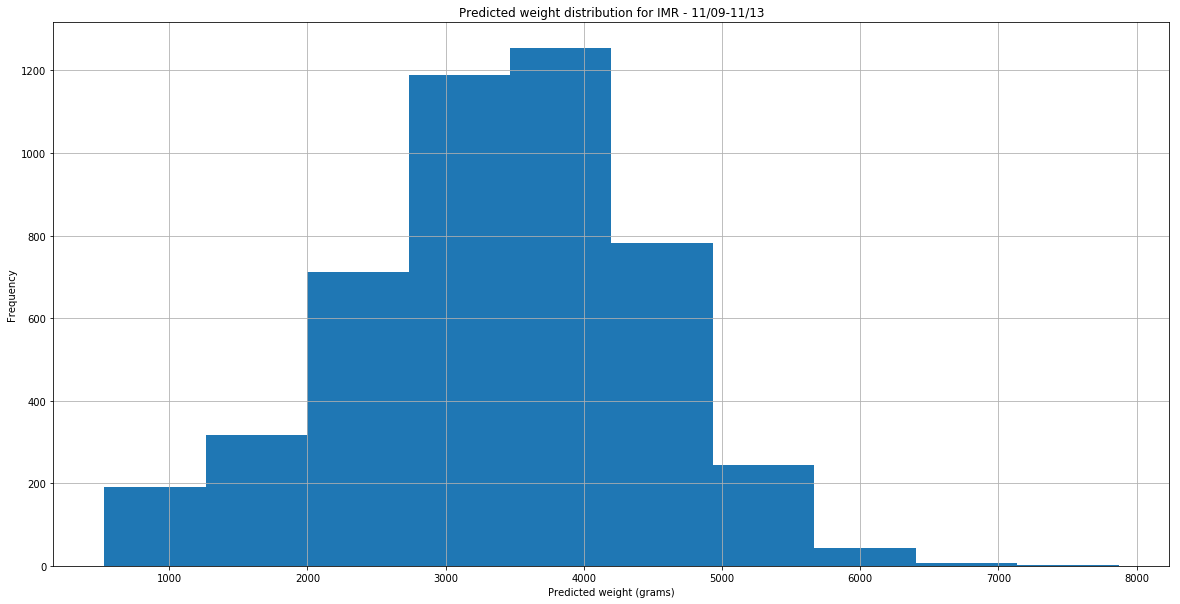

In [54]:
plt.figure(figsize=(20, 10))
mask = df.score > 0.8
plt.hist(df[mask].weight, bins=10)
plt.xlabel('Predicted weight (grams)')
plt.ylabel('Frequency')
plt.title('Predicted weight distribution for IMR - 11/09-11/13')
plt.grid()
plt.show()

In [150]:
def display_crops(left_image_f, right_image_f, left_keypoints, right_keypoints, side='both', overlay_keypoints=True, show_labels=False):
    assert side == 'left' or side == 'right' or side == 'both', \
        'Invalid side value: {}'.format(side)

    if side == 'left' or side == 'right':
        fig, ax = plt.subplots(figsize=(20, 10))
        image_f = left_image_f if side == 'left' else right_image_f
        keypoints = left_keypoints if side == 'left' else right_keypoints
        image = plt.imread(image_f)
        ax.imshow(image)

        if overlay_keypoints:
            for bp, kp in keypoints.items():
#                 ax.scatter([kp[0]], [kp[1]], color='red', s=1)
                ax.scatter([kp[0]], [kp[1]], color='red', s=200, alpha=0.3)
                if show_labels:
                    ax.annotate(bp, (kp[0], kp[1]), color='red')
    else:
        fig, axes = plt.subplots(2, 1, figsize=(20, 20))
        left_image = plt.imread(left_image_f)
        right_image = plt.imread(right_image_f)
        axes[0].imshow(left_image)
        axes[1].imshow(right_image)
        if overlay_keypoints:
            for bp, kp in left_keypoints.items():
#                 axes[0].scatter([kp[0]], [kp[1]], color='red', s=1)
                axes[0].scatter([kp[0]], [kp[1]], color='red', s=200, alpha=0.3)
                if show_labels:
                    axes[0].annotate(bp, (kp[0], kp[1]), color='red')
            for bp, kp in right_keypoints.items():
#                 axes[1].scatter([kp[0]], [kp[1]], color='red', s=1)
                axes[1].scatter([kp[0]], [kp[1]], color='red', s=200, alpha=0.3)
                if show_labels:
                    axes[1].annotate(bp, (kp[0], kp[1]), color='red')
    plt.show()

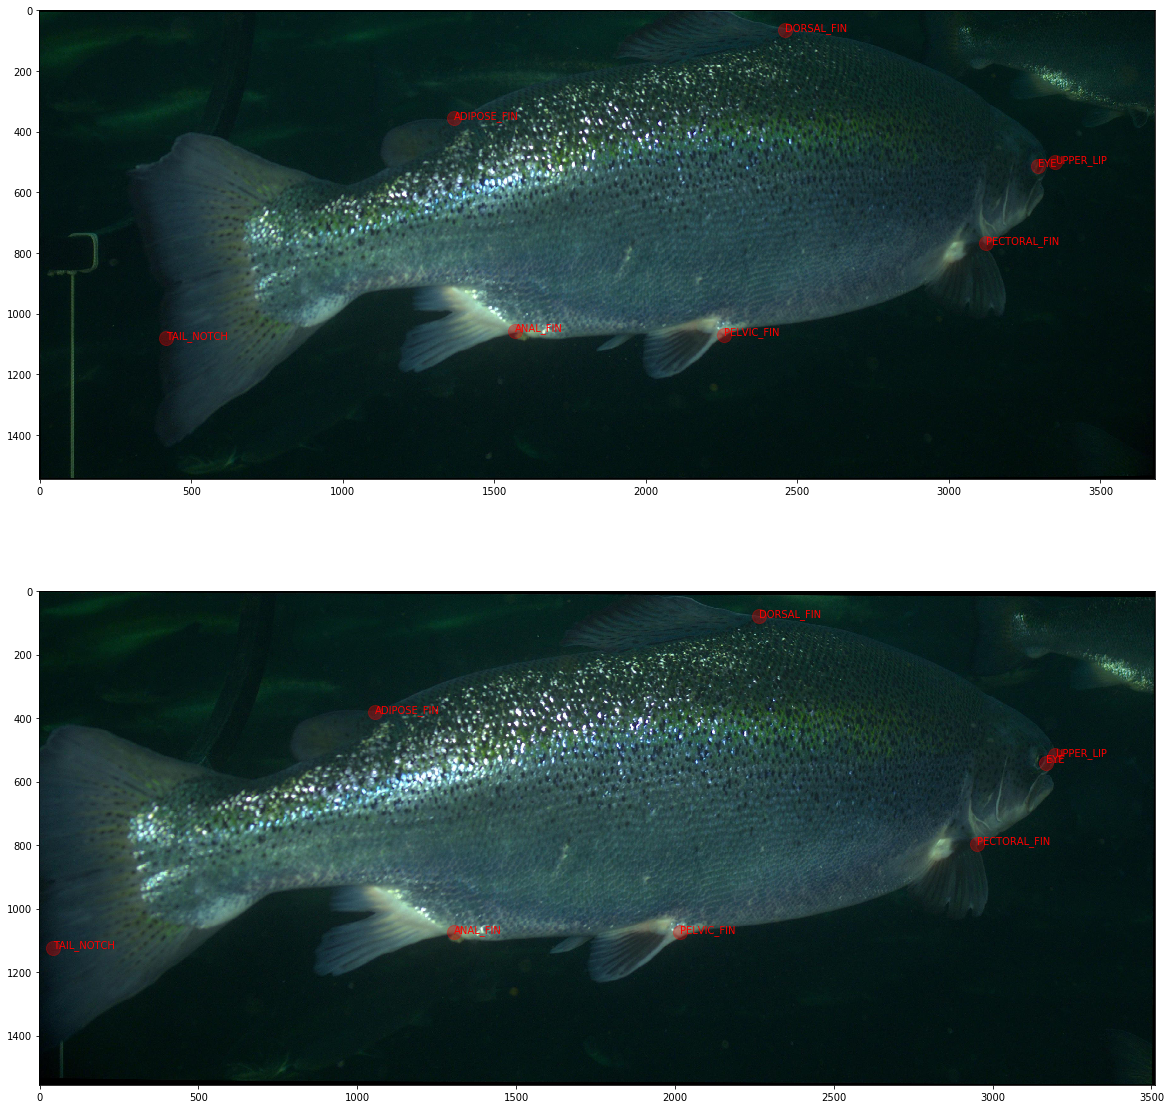

In [166]:
idx = 24
row = df[mask].sort_values('weight', ascending=False).iloc[idx]

left_crop_url, right_crop_url = row.left_crop_url, row.right_crop_url
left_image_f, _, _ = s3_access_utils.download_from_url(left_crop_url)
right_image_f, _, _ = s3_access_utils.download_from_url(right_crop_url)
left_crop_metadata, right_crop_metadata = row.left_crop_metadata, row.right_crop_metadata,
cm = row.camera_metadata
row_id = idx

# run AKPD
akpd_keypoints = akpd.predict_keypoints(left_crop_url, right_crop_url, left_crop_metadata, right_crop_metadata)
left_keypoints = {item['keypointType']: [item['xCrop'], item['yCrop']] for item in akpd_keypoints[0]['leftCrop']}
right_keypoints = {item['keypointType']: [item['xCrop'], item['yCrop']] for item in akpd_keypoints[0]['rightCrop']}


# run AKPD scoring network
input_sample = {
    'keypoints': akpd_keypoints[0],
    'cm': cm,
    'stereo_pair_id': row_id,
    'single_point_inference': True
}
nomralized_centered_2D_kps = \
    normalize_centered_2D_transform_akpd.__call__(input_sample)

akpd_normalized_kps = akpd_normalization_transform.__call__(nomralized_centered_2D_kps)
tensorized_kps = to_tensor_transform.__call__(akpd_normalized_kps)
score = akpd_scorer_network(tensorized_kps['kp_input']).item()
display_crops(left_image_f, right_image_f, left_keypoints, right_keypoints, show_labels=True)


In [144]:
left_crop_url

'https://aquabyte-crops.s3.eu-west-1.amazonaws.com/environment=production/site-id=40/pen-id=61/date=2019-11-10/hour=15/at=2019-11-10T15:14:16.677241000Z/left_frame_crop_1626_1465_4096_2507.jpg'

In [ ]:
3250 = 2070 * (1+r)**60

In [163]:
((3250/2070)**(1/63.0)) - 1

0.007186115970639673

In [164]:
2070*(1.00718)**(51)

2981.4813665497636